In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

In [3]:
news_outlets = pd.read_csv("APRIL2019_DATABASE_State of the Latino News Media - MARCH2019_FINAL_MASTER_DATABASE.csv")
news_outlets.head()

,Estado,State,Medio,Media Outlet,Ciudad,City,Dirección,Zip Code,Latitud,Longitud,...,Fuentes de ingresos,Sources of Revenue,Número de empleados/Number of employees,Frecuencia,Frequency,Facebook,Twitter,Instagram,YouTube,Otra red social
0,Alabama,Alabama,Latino News,Latino News,Trussville,Trussville,PO Box 1313,35173,33.637321,-86.560208,...,NaN,NaN,NaN,Semanario,Weekly,https://www.facebook.com/LatinoNewspaper/,https://twitter.com/latinonews1,NaN,NaN,NaN
1,Alabama,Alabama,Alabama TV,Alabama TV,Hoover,Hoover,"2105 Lorna Ridge Lane, Suite 151",35216,33.391113,-86.796007,...,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/alabamatv/,https://twitter.com/AlabamaTv,https://www.instagram.com/alabamatv/,https://www.youtube.com/channel/UCdXIk0_d5kv_p...,NaN
2,Alabama,Alabama,Líder News,Líder News,Birmingham,Birmingham,PO Box 360535,35236,33.370188,-86.809721,...,Publicidad,Advertising,6-10,Semanal,Weekly,https://www.facebook.com/lidernews.alabama/,NaN,NaN,NaN,NaN
3,Alaska,Alaska,KDMD Telemundo Alaska,KDMD Telemundo Alaska,Anchorage,Anchorage,1310 E. 66th Ave.,99518,61.161005,-149.857320,...,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/Telemundo-Alaska-1662...,https://twitter.com/telemundoalaska,NaN,NaN,NaN
4,Alaska,Alaska,Sol de Medianoche,Sol de Medianoche,Anchorage,Anchorage,PO Box 93466,99501,61.233689,-149.851780,...,Publicidad,Advertising,1-5,Diario,Daily,https://www.facebook.com/soldemedianochenews/,NaN,NaN,NaN,NaN


In [4]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

In [5]:
name_fb = news_outlets[['State','Facebook']].copy()
name_fb = name_fb[name_fb['Facebook'].notna()]

In [6]:
name_fb['clean_url'] = name_fb['Facebook'].apply(clean_address)
name_fb

,State,Facebook,clean_url
0,Alabama,https://www.facebook.com/LatinoNewspaper/,latinonewspaper
1,Alabama,https://www.facebook.com/alabamatv/,alabamatv
2,Alabama,https://www.facebook.com/lidernews.alabama/,lidernews.alabama
3,Alaska,https://www.facebook.com/Telemundo-Alaska-1662...,telemundo-alaska-166204037463565
4,Alaska,https://www.facebook.com/soldemedianochenews/,soldemedianochenews
...,...,...,...
619,Wisconsin,https://www.facebook.com/ElConquistadorNews/,elconquistadornews
620,Wisconsin,https://www.facebook.com/spanishjournal,spanishjournal
621,Wisconsin,https://www.facebook.com/TelemundoWisconsin,telemundowisconsin
622,Wisconsin,https://www.facebook.com/AztecaWisconsin/,aztecawisconsin


In [7]:
republican = pd.read_csv("Trump_Posts.csv")
republican.head(5)

,Page Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,Love,...,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )
0,Mundo Hispánico,mundohispanico,279933092023507,4589078.0,2020-10-02 09:16:36 EDT,Photo,7281,9258,1669,373,...,NaN,https://www.facebook.com/MarioGuevaraNews/phot...,NaN,ΜΗ ÚLTIMA HORA,Mario Guevara,No olviden poner en sus oraciones de este día ...,NaN,NaN,"24,803","24,803"
1,Mundo Hispánico,mundohispanico,279933092023507,4589531.0,2020-10-03 09:17:23 EDT,Photo,3806,7449,904,171,...,NaN,https://www.facebook.com/MarioGuevaraNews/phot...,NaN,NaN,Mario Guevara,PAGARÁN CARO quienes ‘se atrevan’ a publicar m...,NaN,NaN,"17,258","17,258"
2,Mundo Hispánico,mundohispanico,279933092023507,4591995.0,2020-10-09 17:25:48 EDT,Photo,2345,5015,485,137,...,NaN,https://www.facebook.com/MarioGuevaraNews/phot...,NaN,ΜΗ ÚLTIMA HORA,Mario Guevara,¡ES EN SERIO! Presentan ley que busca DESTITUI...,NaN,NaN,"9,645","9,645"
3,Mundo Hispánico,mundohispanico,279933092023507,4592016.0,2020-10-10 23:58:07 EDT,Photo,1814,5266,408,143,...,NaN,https://www.facebook.com/MarioGuevaraNews/phot...,NaN,MUNDO HISPANICO ÚLTIMA HORA,Mario Guevara,ÚLTIMA HORA: Doctor de Trump hace inesperado a...,NaN,NaN,"8,831","8,831"
4,Univision,univision,259955926518,5924926.0,2020-09-18 09:40:03 EDT,Link,1999,1047,1342,180,...,La popular red social TikTok quedará eliminada...,https://www.univision.com/noticias/tecnologia/...,NaN,NaN,Gobierno de Trump anuncia que bloqueará la des...,El Departamento de Comercio anunció la medida ...,NaN,NaN,"5,888","5,888"


In [8]:
republican['URL']

0       https://www.facebook.com/mundohispanico/posts/...
1       https://www.facebook.com/mundohispanico/posts/...
2       https://www.facebook.com/mundohispanico/posts/...
3       https://www.facebook.com/mundohispanico/posts/...
4       https://www.facebook.com/univision/posts/10158...
                              ...                        
9041    https://www.facebook.com/UnivisionNuevoMexico/...
9042    https://www.facebook.com/UnivisionNuevoMexico/...
9043    https://www.facebook.com/UnivisionNuevoMexico/...
9044    https://www.facebook.com/UnivisionNuevoMexico/...
9045    https://www.facebook.com/47ABC/posts/101585049...
Name: URL, Length: 9046, dtype: object

In [9]:
republican['clean_url'] = republican['URL'].apply(clean_address)
republican['clean_url']

0             mundohispanico
1             mundohispanico
2             mundohispanico
3             mundohispanico
4                  univision
                ...         
9041    univisionnuevomexico
9042    univisionnuevomexico
9043    univisionnuevomexico
9044    univisionnuevomexico
9045                   47abc
Name: clean_url, Length: 9046, dtype: object

In [10]:
republican['clean_url'].isna().sum()

0

In [11]:
republican_st =  republican.merge(name_fb, on="clean_url", how="left")
republican_st.loc[republican_st['Page Name'] == 'El Kentubano','State'] = 'Kentucky'

In [12]:
republican_st['State']

0           Georgia
1           Georgia
2           Georgia
3           Georgia
4        California
            ...    
10584           NaN
10585           NaN
10586           NaN
10587           NaN
10588      Maryland
Name: State, Length: 10589, dtype: object

In [13]:
df = republican_st['State'].value_counts().reset_index()
df.columns = ['State','Count']
df

,State,Count
0,Nevada,936
1,Colorado,700
2,Massachusetts,616
3,Florida,596
4,Georgia,595
5,California,593
6,New York,523
7,Arizona,523
8,Puerto Rico,520
9,Illinois,451


In [14]:
df.to_csv('Republican.csv',index=False)

In [15]:
republican.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'clean_url'],
      dtype='object')

In [16]:
message = republican[['Message','Description']]
message

,Message,Description
0,NaN,No olviden poner en sus oraciones de este día ...
1,NaN,PAGARÁN CARO quienes ‘se atrevan’ a publicar m...
2,NaN,¡ES EN SERIO! Presentan ley que busca DESTITUI...
3,NaN,ÚLTIMA HORA: Doctor de Trump hace inesperado a...
4,La popular red social TikTok quedará eliminada...,El Departamento de Comercio anunció la medida ...
...,...,...
9041,A menos de 3 meses de unas elecciones que debe...,NaN
9042,Los demócratas montaron un espectáculo inclusi...,NaN
9043,Trump reveló la verdadera razón por la que no ...,#EstaSemana: Trump reveló hoy la verdadera raz...
9044,"""No sólo era mi hermano, era mi mejor amigo”, ...",-


In [17]:
content = message['Message'].fillna('') + (' ' + message['Description']).fillna('')

content = pd.DataFrame(content)
content.columns = ['Message']
content

,Message
0,No olviden poner en sus oraciones de este día...
1,PAGARÁN CARO quienes ‘se atrevan’ a publicar ...
2,¡ES EN SERIO! Presentan ley que busca DESTITU...
3,ÚLTIMA HORA: Doctor de Trump hace inesperado ...
4,La popular red social TikTok quedará eliminada...
...,...
9041,A menos de 3 meses de unas elecciones que debe...
9042,Los demócratas montaron un espectáculo inclusi...
9043,Trump reveló la verdadera razón por la que no ...
9044,"""No sólo era mi hermano, era mi mejor amigo”, ..."


In [18]:
content['cleanMessage'] = content['Message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage']

0        No olviden poner en sus oraciones de este día...
1        PAGARÁN CARO quienes ‘se atrevan’ a publicar ...
2        ¡ES EN SERIO! Presentan ley que busca DESTITU...
3        ÚLTIMA HORA: Doctor de Trump hace inesperado ...
4       La popular red social TikTok quedará eliminada...
                              ...                        
9041    A menos de 3 meses de unas elecciones que debe...
9042    Los demócratas montaron un espectáculo inclusi...
9043    Trump reveló la verdadera razón por la que no ...
9044    "No sólo era mi hermano, era mi mejor amigo”, ...
9045    Governor John Carney has submitted a formal re...
Name: cleanMessage, Length: 9046, dtype: object

In [42]:
# Convert to list
data = content.cleanMessage.tolist()

In [41]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

## Tokenize words and Clean-up text

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['no', 'olviden', 'poner', 'en', 'sus', 'oraciones', 'de', 'este', 'dia', 'al', 'presidente', 'de', 'esta', 'bella', 'nacion', 'donald', 'trump', 'su', 'familia', 'el', 'mandatario', 'resulto', 'positivo', 'al', 'covid', 'al', 'igual', 'que', 'su', 'esposa', 'tambien', 'por', 'las', 'demas', 'personas', 'en', 'el', 'mundo', 'que', 'sufren', 'de', 'este', 'mal', 'que', 'dios', 'les', 'permita', 'salir', 'de', 'esta', 'dura', 'prueba', 'pronto', 'detalles']]


## Creating Bigram and Trigram Models

In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['no', 'olviden', 'poner', 'en', 'sus', 'oraciones', 'de', 'este', 'dia', 'al', 'presidente', 'de', 'esta', 'bella', 'nacion', 'donald', 'trump', 'su', 'familia', 'el', 'mandatario', 'resulto', 'positivo', 'al', 'covid', 'al', 'igual', 'que', 'su', 'esposa', 'tambien', 'por', 'las', 'demas', 'personas', 'en', 'el', 'mundo', 'que', 'sufren', 'de', 'este', 'mal', 'que', 'dios', 'les', 'permita', 'salir', 'de', 'esta', 'dura', 'prueba', 'pronto', 'detalles']


## Remove Stopwords, Make Bigrams and Lemmatize


In [23]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['olvidar', 'poner', 'oración', 'presidente', 'resultar', 'positivo', 'covid', 'igual', 'esposo', 'tambien', 'demas', 'personar', 'mal', 'permitir', 'salir', 'duro', 'probar', 'pronto', 'detalle']]


## Create the Dictionary and Corpus needed for Topic Modeling

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


[[('covid', 1),
  ('demas', 1),
  ('detalle', 1),
  ('duro', 1),
  ('esposo', 1),
  ('igual', 1),
  ('mal', 1),
  ('olvidar', 1),
  ('oración', 1),
  ('permitir', 1),
  ('personar', 1),
  ('poner', 1),
  ('positivo', 1),
  ('presidente', 1),
  ('probar', 1),
  ('pronto', 1),
  ('resultar', 1),
  ('salir', 1),
  ('tambien', 1)]]

## Building the Topic Model

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [27]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.166*"dar" + 0.135*"segundar" + 0.081*"seguidor" + 0.057*"creer" + '
  '0.049*"hispano" + 0.049*"poner" + 0.045*"casi" + 0.044*"contagiar" + '
  '0.028*"miembro" + 0.024*"cortar"'),
 (1,
  '0.287*"personar" + 0.102*"tratamiento" + 0.093*"criticar" + 0.070*"tomar" + '
  '0.057*"pedir" + 0.043*"medicar" + 0.037*"indicar" + 0.031*"proximas" + '
  '0.015*"fuente" + 0.013*"caravana"'),
 (2,
  '0.082*"politicos" + 0.077*"destacar" + 0.068*"afirmar" + 0.045*"corrupto" + '
  '0.025*"isla" + 0.024*"acuerdo" + 0.004*"volvio" + '
  '0.000*"organizacion_mundial" + 0.000*"liderar" + 0.000*"palabra"'),
 (3,
  '0.102*"electoral" + 0.096*"ultimar" + 0.093*"noticiar" + 0.088*"detalle" + '
  '0.082*"octubre" + 0.069*"mandatario" + 0.066*"muerte" + 0.049*"dia" + '
  '0.047*"ir" + 0.045*"virus"'),
 (4,
  '0.521*"trump" + 0.288*"presidente" + 0.046*"anunciar" + 0.041*"ano" + '
  '0.033*"estadounidense" + 0.011*"nominar" + 0.009*"obtener" + 0.008*"lograr" '
  '+ 0.007*"fin" + 0.002*"paz"'),
 (5,
  

## Compute Model Perplexity and Coherence Score


In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -18.048771721261165

Coherence Score:  0.3683195104216984


## Visualize the topics-keywords

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.386091  0.274944       1        1  23.151882
18     0.140054 -0.189633       2        1   9.326200
19     0.160725 -0.296851       3        1   8.190906
8      0.036843 -0.011738       4        1   6.289320
3      0.029697 -0.007934       5        1   5.864567
12     0.044836 -0.017811       6        1   5.681680
15     0.022840 -0.003864       7        1   5.342604
17     0.024165 -0.005510       8        1   4.992920
16     0.026593 -0.006586       9        1   4.828653
13     0.022545 -0.003484      10        1   4.624637
7      0.019848 -0.002450      11        1   4.589910
0     -0.008581  0.011312      12        1   4.299272
1     -0.065195  0.027574      13        1   2.938362
6     -0.082264  0.030544      14        1   2.379149
11    -0.113767  0.034638      15        1   2.066742
5     -0.098702  0.033164      16        1   1.993377
10    -0.091605  0.032071      17        1   1.540399
14    -0.133120  0.035553      18        1   1.247253
2     -0.158564  0.033443      19        1   0.488521
9     -0.162441  0.032617      20        1   0.163654, topic_info=             Term          Freq         Total Category  logprob  loglift
25          trump  14427.000000  14427.000000  Default  30.0000  30.0000
13     presidente   7969.000000   7969.000000  Default  29.0000  29.0000
77          decir   3054.000000   3054.000000  Default  28.0000  28.0000
186   coronavirus   2078.000000   2078.000000  Default  27.0000  27.0000
188       debatir   2403.000000   2403.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1591        padre      0.018435      1.822533  Topic20  -9.2709   1.8214
744         fecho      0.018434      1.822321  Topic20  -9.2709   1.8215
1666    proyectar      0.018434      1.822340  Topic20  -9.2709   1.8215
953        podria      0.018434      1.822589  Topic20  -9.2709   1.8214
508        millón      0.018434      1.823407  Topic20  -9.2709   1.8209

[786 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
249       2  0.962529   accionar
239      11  0.992074     acepto
217       8  0.994876    acordar
404      20  0.935804  activista
381       2  0.974241     actriz
...     ...       ...        ...
268      19  0.497376     volvio
453       6  0.997408    votante
123       7  0.998614      votar
161      12  0.970054       voto
320       3  0.997912         ﻿1

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 19, 20, 9, 4, 13, 16, 18, 17, 14, 8, 1, 2, 7, 12, 6, 11, 15, 3, 10])

## Building LDA Mallet Model

In [30]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [31]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(17,
  [('elección', 0.10303877052043312),
   ('campana', 0.07527069507509605),
   ('noviembre', 0.05396437303527768),
   ('martes', 0.042787286063569685),
   ('vez', 0.04243800209570381),
   ('electoral', 0.041739434159972055),
   ('miercoles', 0.03964373035277681),
   ('primero', 0.03719874257771568),
   ('presidente', 0.03300733496332518),
   ('vicepresidente', 0.026720223541739436)]),
 (19,
  [('inmigrante', 0.04656101944126777),
   ('familia', 0.024995915700049012),
   ('politica', 0.02385231171377226),
   ('padre', 0.0222185917333769),
   ('unir', 0.02025812775690247),
   ('juez', 0.018461035778467572),
   ('federal', 0.017317431792190818),
   ('abogar', 0.016500571801993137),
   ('cortar', 0.013723247835321027),
   ('ninos', 0.013233131841202417)]),
 (7,
  [('ano', 0.07432110528823249),
   ('millón', 0.055423217405113544),
   ('pagar', 0.035572494838812134),
   ('solo', 0.034619660155629665),
   ('dolar', 0.03239637922820391),
   ('impuesto', 0.03144354454502144),
   ('vacuno',

## Finding the optimal number of topics for LDA

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

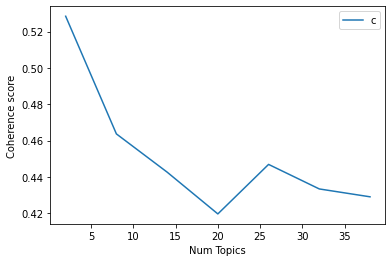

In [34]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5284
Num Topics = 8  has Coherence Value of 0.4636
Num Topics = 14  has Coherence Value of 0.4426
Num Topics = 20  has Coherence Value of 0.4196
Num Topics = 26  has Coherence Value of 0.4468
Num Topics = 32  has Coherence Value of 0.4333
Num Topics = 38  has Coherence Value of 0.429


In [36]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.148*"decir" + 0.083*"trump" + 0.074*"presidente" + 0.029*"martes" + '
  '0.025*"mensaje" + 0.021*"semana" + 0.020*"ayudar" + 0.017*"respuesta" + '
  '0.016*"preguntar" + 0.014*"aprobar"'),
 (1,
  '0.046*"presidente" + 0.032*"unir" + 0.027*"llegar" + 0.025*"acordar" + '
  '0.018*"despues" + 0.017*"vacuno" + 0.017*"mexico" + 0.016*"salud" + '
  '0.013*"experto" + 0.012*"usar"'),
 (2,
  '0.064*"presidente" + 0.050*"estadounidense" + 0.047*"trump" + '
  '0.020*"acusar" + 0.019*"llamar" + 0.017*"tratar" + 0.015*"domingo" + '
  '0.015*"septiembre" + 0.015*"ir" + 0.013*"partir"'),
 (3,
  '0.031*"inmigrante" + 0.029*"nuevo" + 0.023*"medir" + 0.019*"presentar" + '
  '0.018*"programar" + 0.017*"familia" + 0.015*"politica" + 0.015*"padre" + '
  '0.013*"federal" + 0.013*"tambien"'),
 (4,
  '0.055*"mas" + 0.024*"semana" + 0.019*"encuestar" + 0.018*"hispano" + '
  '0.017*"votante" + 0.017*"latino" + 0.016*"personar" + 0.015*"mostrar" + '
  '0.014*"mayor" + 0.012*"pandemia"'),
 (5,
  '0.121

##  Finding the dominant topic in each sentence

In [37]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1291,"coronavirus, anunciar, dar, presidente, positi...",No olviden poner en sus oraciones de este día...
1,1,11.0,0.0997,"trump, presidente, ahora, ee_uu, hablar, ver, ...",PAGARÁN CARO quienes ‘se atrevan’ a publicar ...
2,2,8.0,0.1133,"trump, hacer, ser, decir, poder, presidente, d...",¡ES EN SERIO! Presentan ley que busca DESTITU...
3,3,7.0,0.0955,"presidente, mandatario, casa_blanca, publicar,...",ÚLTIMA HORA: Doctor de Trump hace inesperado ...
4,4,2.0,0.1415,"presidente, estadounidense, trump, acusar, lla...",La popular red social TikTok quedará eliminada...
5,5,11.0,0.1258,"trump, presidente, ahora, ee_uu, hablar, ver, ...",“Quieren 52 o 53 estados…¿Cómo va a lucir la b...
6,6,11.0,0.1094,"trump, presidente, ahora, ee_uu, hablar, ver, ...",TODOS CONTRA TRUMP. Con tal de sacar al presid...
7,7,5.0,0.0941,"elección, republicano, votar, noviembre, campa...",Opinión El Nuevo Día | Si es relecto como pres...
8,8,11.0,0.1354,"trump, presidente, ahora, ee_uu, hablar, ver, ...",¡EL PEOR MIEDO DE TRUMP! Nueva caravana de mi...
9,9,8.0,0.1215,"trump, hacer, ser, decir, poder, presidente, d...",ÚLTIMA HORA: Trump ROMPE SILENCIO y envía men...


## Find the most representative document for each topic

In [38]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3087,"decir, trump, presidente, martes, mensaje, sem...",𝐓𝐫𝐮𝐦𝐩 𝐩𝐫𝐨𝐩𝐨𝐧𝐞 𝐚𝐥 𝐂𝐨𝐧𝐠𝐫𝐞𝐬𝐨 𝐮𝐧 𝐬𝐞𝐠𝐮𝐧𝐝𝐨 𝐜𝐡𝐞𝐪𝐮𝐞 𝐝𝐞...
1,1.0,0.4887,"presidente, unir, llegar, acordar, despues, va...",Benjamin Netanyahu: Estoy muy emocionado de ha...
2,2.0,0.5001,"presidente, estadounidense, trump, acusar, lla...",Trump supuestamente tildó de estúpida la guerr...
3,3.0,0.4887,"inmigrante, nuevo, medir, presentar, programar...",INMIGRACIÓN Gobierno no admitirá nuevos solici...
4,4.0,0.5034,"mas, semana, encuestar, hispano, votante, lati...","𝐂𝐫𝐞𝐜𝐞 𝐜𝐨𝐧𝐟𝐢𝐚𝐧𝐳𝐚 𝐝𝐞 𝐥𝐚𝐭𝐢𝐧𝐨𝐬 𝐞𝐧 𝐁𝐢𝐝𝐞𝐧, 𝐦𝐢𝐞𝐧𝐭𝐫𝐚𝐬 ..."


In [46]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"coronavirus, anunciar, dar, presidente, positivo, trump, viernes, despues, luego, covid",855.0,0.0945
1.0,11.0,"trump, presidente, ahora, ee_uu, hablar, ver, podria, nuevo, muerte, posible",552.0,0.0610
2.0,8.0,"trump, hacer, ser, decir, poder, presidente, dejar, mujer, nominar, juez",518.0,0.0573
3.0,7.0,"presidente, mandatario, casa_blanca, publicar, lunes, estadounidense, bien, virus, hora, asegurar",691.0,0.0764
4.0,2.0,"presidente, estadounidense, trump, acusar, llamar, tratar, domingo, septiembre, ir, partir",453.0,0.0501
5.0,11.0,"trump, presidente, ahora, ee_uu, hablar, ver, podria, nuevo, muerte, posible",761.0,0.0841
6.0,11.0,"trump, presidente, ahora, ee_uu, hablar, ver, podria, nuevo, muerte, posible",559.0,0.0618
7.0,5.0,"elección, republicano, votar, noviembre, campana, democrata, candidato, electoral, democratas, vez",682.0,0.0754
8.0,11.0,"trump, presidente, ahora, ee_uu, hablar, ver, podria, nuevo, muerte, posible",575.0,0.0636
9.0,8.0,"trump, hacer, ser, decir, poder, presidente, dejar, mujer, nominar, juez",689.0,0.0762
